# README

### Shear Stress Analysis of Reinforced Concrete Beams using Machine Learning Algorithms

This code is broken down into 6 main parts:

*   Data/Package Importation
*   Pre-Processing & Feature Engineering for Classification
*   Classification Model Training
*   Pre-Processing & Feature Engineering for Regression
*   Regression Model Training
*   Model Evaluation

Each part is dependent on the previous section so code must be ran in order


# Data/Package Importation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import csv
from sklearn.preprocessing import StandardScaler
from itertools import combinations
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss, make_scorer
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv('Beams_ML.csv')

# Pre-Processing & Feature Engineering for Classification

In [4]:
#Define a function to assign beam class based on value of shear span ratio
def classify_beam(a_d):
    if a_d < 1:
        return "very short"
    elif 1 <= a_d < 2.5:
        return "short"
    elif 2.5 <= a_d < 6:
        return "slender"
    else:
        return "very slender"

# Apply beam class function and append column to dataframe
df['beam_class'] = df['a_d'].apply(lambda x: classify_beam(x))

Seperate Beams with and without shear reinforcement

In [5]:
df_withshear = df[df['Av'] != 0]
df_withoutshear = df[df['Av'] == 0]

Standardize Classification Features for each data frame

In [6]:
# Define a function to standardize the features
def standardize_features(df):
    scaler = StandardScaler()
    scaled_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    return scaled_df

In [7]:
classification_features_shear = df_withshear[["Mn", "Mf", "Mf_Mn", "fpc", "fcttest", "agg", "L", "aa", "ba", "a_d", "M_Vd"]]
classification_features_shear = standardize_features(classification_features_shear)
classification_features_no_shear = df_withoutshear[["Mn", "Mf", "Mf_Mn", "fpc", "fcttest", "agg", "L", "aa", "ba", "a_d", "M_Vd"]]
classification_features_no_shear = standardize_features(classification_features_no_shear)

# Classification Model Training

## Beams with Shear Reinforcement

Exhaustive Search for Beams with Shear Reinforcement using SVC

In [71]:
# Extract features and target variable
X = classification_features_shear.values  # Features
y = df_withshear['beam_class']  # Target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# List to store results
results = []

# Iterate through all possible combinations of features
for r in range(1, len(classification_features_shear.columns) + 1):
    for feature_combo in combinations(classification_features_shear.columns, r):
        # Extract features based on the current combination
        X_train_subset = X_train[:, classification_features_shear.columns.isin(feature_combo)]
        X_test_subset = X_test[:, classification_features_shear.columns.isin(feature_combo)]

        # Train SVM classifier
        svm = SVC()
        svm.fit(X_train_subset, y_train)

        # Make predictions
        y_pred = svm.predict(X_test_subset)

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)

        # Store results
        results.append((feature_combo, accuracy))

# Sort results by accuracy
results.sort(key=lambda x: x[1], reverse=True)

#Extract combination of inputs that yields highest accuracy
top_features_shear, top_accuracy_shear = results[0]

# Print top combinations and their accuracies
for i in range(5):  # Print top 5 combinations
    print("Features:", results[i][0])
    print("Accuracy:", results[i][1])
    print()

Features: ('Mf', 'aa', 'a_d', 'M_Vd')
Accuracy: 1.0

Features: ('Mn', 'agg', 'a_d')
Accuracy: 0.9692307692307692

Features: ('Mf', 'agg', 'a_d')
Accuracy: 0.9692307692307692

Features: ('Mf', 'a_d', 'M_Vd')
Accuracy: 0.9692307692307692

Features: ('Mf', 'Mf_Mn', 'a_d', 'M_Vd')
Accuracy: 0.9692307692307692



Use the best features from the exhaustive search in a Random Forest Classifier

Accuracy: 1.0


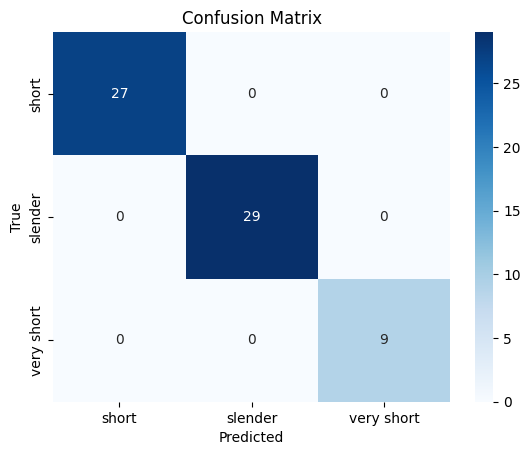

In [ ]:
# Extract features and target variable
X = classification_features_shear[list(top_features_shear)]  # Features
y = df_withshear['beam_class']  # Target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Confusion Matrix for Beams with Shear Reinforcement

In [ ]:

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Accuracy Learning Curve for Random Forest

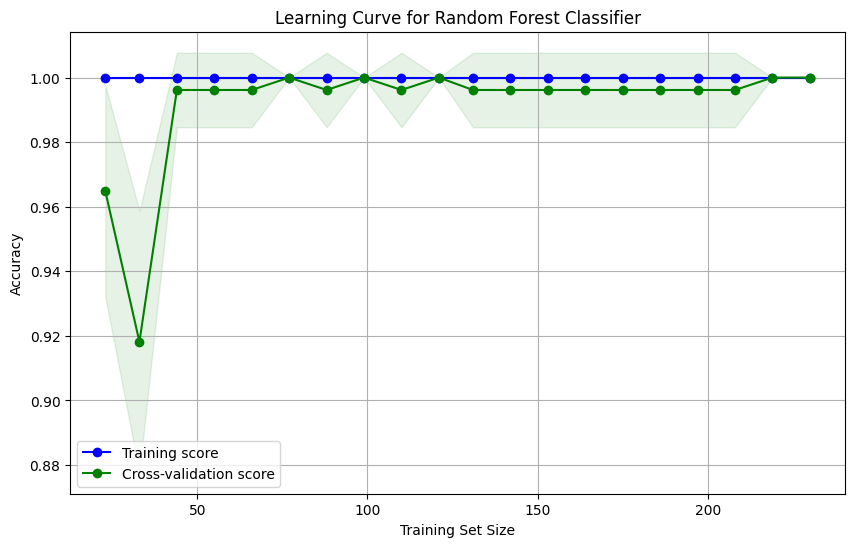

Test Set Accuracy: 1.0


In [ ]:
# Split the data into features (X) and the target variable (y)
X = classification_features_shear[list(top_features_shear)]
y = df_withshear['beam_class']  # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Generate learning curve data
train_sizes, train_scores, validation_scores = learning_curve(
    estimator=rf,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 20),
    cv=10,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

# Calculate mean and standard deviation of training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training score')
plt.plot(train_sizes, validation_scores_mean, 'o-', color='green', label='Cross-validation score')

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.1, color='green')

plt.title('Learning Curve for Random Forest Classifier')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()

# Train the classifier on the full training data
rf.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = rf.predict(X_test)

# Calculate the accuracy of the classifier on the test set
accuracy = accuracy_score(y_test, y_pred)
print("Test Set Accuracy:", accuracy)


Log Loss Learning Curve for Random Forest

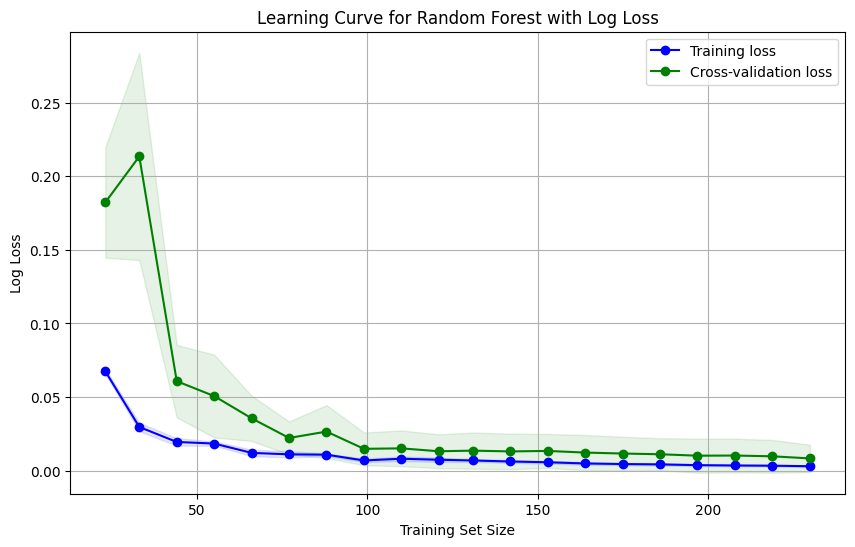

In [ ]:
# Split the data into features (X) and the target variable (y)
X = classification_features_shear[list(top_features_shear)]
y = df_withshear['beam_class']  # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Generate learning curve data with log_loss
train_sizes, train_scores, validation_scores = learning_curve(
    estimator=rf,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 20),
    cv=10,
    scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True),
    n_jobs=-1,
    random_state=42
)

# Calculate mean and standard deviation of training and validation scores
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = -np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training loss')
plt.plot(train_sizes, validation_scores_mean, 'o-', color='green', label='Cross-validation loss')

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.1, color='green')

plt.title('Learning Curve for Random Forest with Log Loss')
plt.xlabel('Training Set Size')
plt.ylabel('Log Loss')
plt.legend(loc='best')
plt.grid()
plt.show()

## Beams without Shear Reinforcement

Exhaustive Search for Beams without Shear Reinforcement using SVC

In [228]:
# Extract features and target variable
X = classification_features_no_shear.values  # Features
y = df_withoutshear['beam_class']  # Target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# List to store results
results = []

# Iterate through all possible combinations of features
for r in range(1, len(classification_features_shear.columns) + 1):
    for feature_combo in combinations(classification_features_no_shear.columns, r):
        # Extract features based on the current combination
        X_train_subset = X_train[:, classification_features_no_shear.columns.isin(feature_combo)]
        X_test_subset = X_test[:, classification_features_no_shear.columns.isin(feature_combo)]

        # Train SVM classifier
        svm = SVC()
        svm.fit(X_train_subset, y_train)

        # Make predictions
        y_pred = svm.predict(X_test_subset)

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)

        # Store results
        results.append((feature_combo, accuracy))

# Sort results by accuracy
results.sort(key=lambda x: x[1], reverse=True)

#Extract combination of inputs that yields highest accuracy
top_features_no_shear, top_accuracy_no_shear = results[0]

# Print top combinations and their accuracies
for i in range(5):  # Print top 5 combinations
    print("Features:", results[i][0])
    print("Accuracy:", results[i][1])
    print()

Features: ('L', 'a_d')
Accuracy: 0.9895833333333334

Features: ('Mf', 'L', 'a_d')
Accuracy: 0.9895833333333334

Features: ('L', 'a_d', 'M_Vd')
Accuracy: 0.9895833333333334

Features: ('Mn', 'L', 'a_d', 'M_Vd')
Accuracy: 0.9895833333333334

Features: ('Mf', 'Mf_Mn', 'L', 'a_d')
Accuracy: 0.9895833333333334



Use the best features from the exhaustive search in a Random Forest Classifier

Accuracy: 1.0


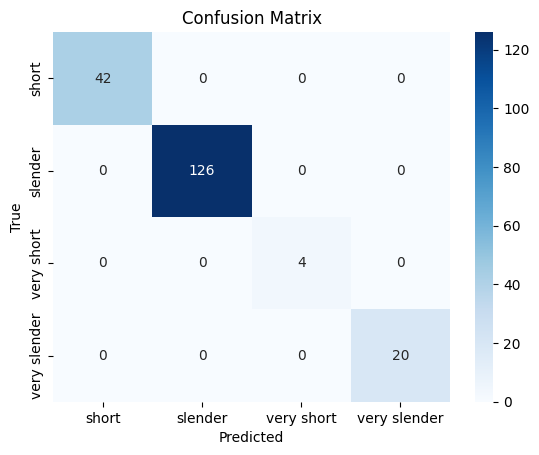

In [ ]:
# Extract features and target variable
X = classification_features_no_shear[list(top_features_no_shear)]  # Features
y = df_withoutshear['beam_class']  # Target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)



Confusion Matrix for Beams without Shear Reinforcement

In [ ]:
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Accuracy Learning Curve for Random Forest

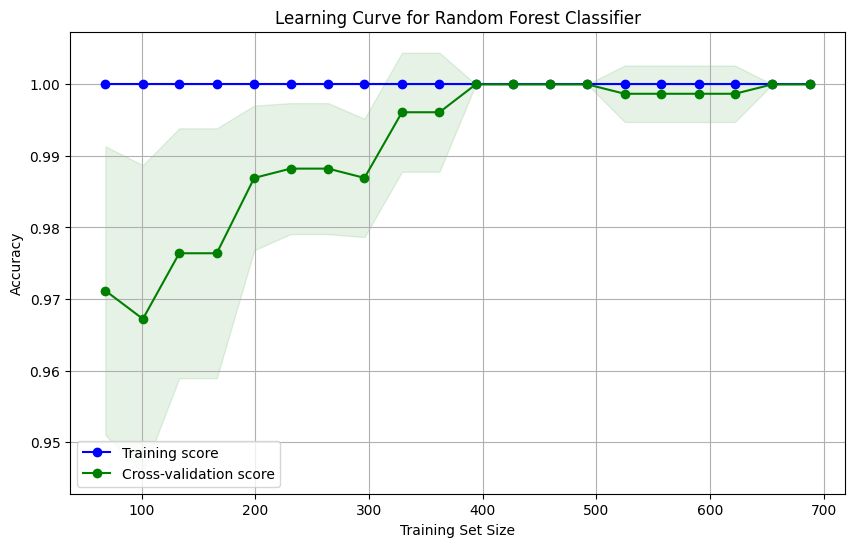

Test Set Accuracy: 1.0


In [ ]:
# Split the data into features (X) and the target variable (y)
X = classification_features_no_shear[list(top_features_no_shear)]
y = df_withoutshear['beam_class']  # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Generate learning curve data
train_sizes, train_scores, validation_scores = learning_curve(
    estimator=rf,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 20),
    cv=10,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

# Calculate mean and standard deviation of training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training score')
plt.plot(train_sizes, validation_scores_mean, 'o-', color='green', label='Cross-validation score')

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.1, color='green')

plt.title('Learning Curve for Random Forest Classifier')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()

# Train the classifier on the full training data
rf.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = rf.predict(X_test)

# Calculate the accuracy of the classifier on the test set
accuracy = accuracy_score(y_test, y_pred)
print("Test Set Accuracy:", accuracy)


Log Loss Learning Curve for Random Forest
Beams without Shear Reinforcement

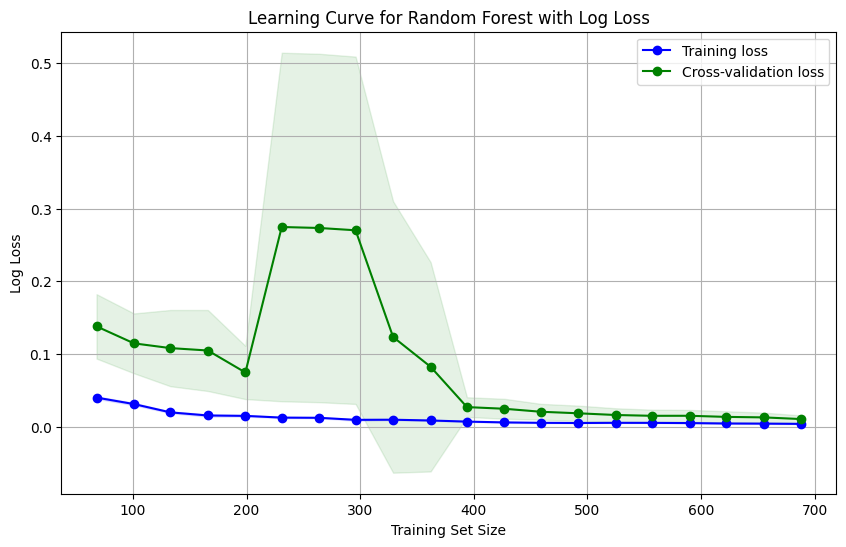

In [ ]:
# Split the data into features (X) and the target variable (y)
X = classification_features_no_shear[list(top_features_no_shear)]
y = df_withoutshear['beam_class']  # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Generate learning curve data with log_loss
train_sizes, train_scores, validation_scores = learning_curve(
    estimator=rf,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 20),
    cv=10,
    scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True),
    n_jobs=-1,
    random_state=42
)

# Calculate mean and standard deviation of training and validation scores
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = -np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training loss')
plt.plot(train_sizes, validation_scores_mean, 'o-', color='green', label='Cross-validation loss')

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.1, color='green')

plt.title('Learning Curve for Random Forest with Log Loss')
plt.xlabel('Training Set Size')
plt.ylabel('Log Loss')
plt.legend(loc='best')
plt.grid()
plt.show()

# Pre-Processing & Feature Engineering for Regression



Create featurre Stress

In [9]:
df_withshear['Stress'] = df_withshear['Vtest'] / df_withshear['bw'] * df_withshear['d']
df_withoutshear['Stress'] = df_withoutshear['Vtest'] / df_withoutshear['bw'] * df_withoutshear['d']

<ipython-input-9-95c59a2154f2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_withshear['Stress'] = df_withshear['Vtest'] / df_withshear['bw'] * df_withshear['d']
<ipython-input-9-95c59a2154f2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_withoutshear['Stress'] = df_withoutshear['Vtest'] / df_withoutshear['bw'] * df_withoutshear['d']


Select all numerical features for regression models, and beam class to identify subset for regression

In [10]:
df_withshear = df_withshear[["h", "dp", "ds", "d", "bw", "btop", "bbot", "ttop", "tbot", "bslab", "tslab", "yb", "egc", "Ag", "Ig", "Ic","L", "aa", "ba", "a_d", "M_Vd","fpc", "fcttest", "agg","As", "fy", "rhol","Av", "fvy", "sv", "rhov", "rhovfvy", "L", "aa", "ba", 'beam_class', 'Stress', 'Vtest']]
df_withoutshear = df_withoutshear[["h", "dp", "ds", "d", "bw", "btop", "bbot", "ttop", "tbot", "bslab", "tslab", "yb", "egc", "Ag", "Ig", "Ic","L", "aa", "ba", "a_d", "M_Vd","fpc", "fcttest", "agg","As", "fy", "rhol","L", "aa", "ba", "beam_class", 'Stress', 'Vtest']]

Separate beams by beam class

In [11]:
short_shear = df_withshear[df_withshear['beam_class'] == 'short']
very_short_shear = df_withshear[df_withshear['beam_class'] == 'very short']
slender_shear = df_withshear[df_withshear['beam_class'] == 'slender']

short_no_shear = df_withoutshear[df_withoutshear['beam_class'] == 'short']
very_short_no_shear = df_withoutshear[df_withoutshear['beam_class'] == 'very short']
slender_no_shear = df_withoutshear[df_withoutshear['beam_class'] == 'slender']
very_slender_no_shear = df_withoutshear[df_withoutshear['beam_class'] == 'very slender']

Calculate the loading at failure per ACI standard

In [ ]:
def calculate_vaci_from_df(df):

    fpc = df['fpc']
    bw = df['bw']
    d = df['d']
    Vaci_values = 2 * np.sqrt(fpc) * (bw * d)
    return Vaci_values

In [12]:
short_shear_comp = pd.DataFrame({ 'V_ACI_Prediction': calculate_vaci_from_df(short_shear)})
very_short_shear_comp = pd.DataFrame({ 'V_ACI_Prediction': calculate_vaci_from_df(very_short_shear)})
slender_shear_comp = pd.DataFrame({ 'V_ACI_Prediction': calculate_vaci_from_df(slender_shear)})

short_no_shear_comp = pd.DataFrame({ 'V_ACI_Prediction': calculate_vaci_from_df(short_no_shear)})
very_short_no_shear_comp = pd.DataFrame({ 'V_ACI_Prediction': calculate_vaci_from_df(very_short_no_shear)})
slender_no_shear_comp = pd.DataFrame({ 'V_ACI_Prediction': calculate_vaci_from_df(slender_no_shear)})
very_slender_no_shear_comp = pd.DataFrame({ 'V_ACI_Prediction': calculate_vaci_from_df(very_slender_no_shear)})

In [13]:
short_shear_comp['Vtest'] = short_shear['Vtest']
very_short_shear_comp['Vtest'] = very_short_shear['Vtest']
slender_shear_comp['Vtest'] = slender_shear['Vtest']

short_no_shear_comp['Vtest'] = short_no_shear['Vtest']
very_short_no_shear_comp['Vtest'] = very_short_no_shear['Vtest']
slender_no_shear_comp['Vtest'] = slender_no_shear['Vtest']
very_slender_no_shear_comp['Vtest'] = very_slender_no_shear['Vtest']

Drop beam class to ensure all features are numeric within subset

In [15]:
short_shear = short_shear.drop(columns=['beam_class'])
very_short_shear = very_short_shear.drop(columns=['beam_class'])
slender_shear = slender_shear.drop(columns=['beam_class'])

short_no_shear = short_no_shear.drop(columns=['beam_class'])
very_short_no_shear = very_short_no_shear.drop(columns=['beam_class'])
slender_no_shear = slender_no_shear.drop(columns=['beam_class'])
very_slender_no_shear = very_slender_no_shear.drop(columns=['beam_class'])

short_shear = short_shear.drop(columns=['Vtest'])
very_short_shear = very_short_shear.drop(columns=['Vtest'])
slender_shear = slender_shear.drop(columns=['Vtest'])

short_no_shear = short_no_shear.drop(columns=['Vtest'])
very_short_no_shear = very_short_no_shear.drop(columns=['Vtest'])
slender_no_shear = slender_no_shear.drop(columns=['Vtest'])
very_slender_no_shear = very_slender_no_shear.drop(columns=['Vtest'])

Standardize features

In [16]:
short_shear_sd = standardize_features(short_shear)
very_short_shear_sd = standardize_features(very_short_shear)
slender_shear_sd = standardize_features(slender_shear)

short_no_shear_sd = standardize_features(short_no_shear)
very_short_no_shear_sd = standardize_features(very_short_no_shear)
slender_no_shear_sd = standardize_features(slender_no_shear)
very_slender_no_shear_sd = standardize_features(very_slender_no_shear)

# Regression Models Training

## Regression Models for Beams with Shear Reinforcement

### Regression for Very Short Beams with Shear Reinforcement:

Use PCA dimensionalality reduction technique on entire subset


In [1]:
# Assuming very_short_shear is your DataFrame
X = very_short_shear_sd.drop('Stress', axis=1)  # Features
y = very_short_shear_sd['Stress']  # Target variable (if needed for later analysis)

pca = PCA(n_components=.99)  # Choose the number of principal components
X_pca = pca.fit_transform(X)

kmeans = KMeans(n_clusters=2, random_state=42)  # Adjust number of clusters as needed
kmeans.fit(X_pca)
y_kmeans = kmeans.predict(X_pca)

cluster_labels = np.unique(y_kmeans)
for label in cluster_labels:
    print(f'Cluster {label}: {np.sum(y_kmeans == label)} points')

plt.figure(figsize=(8, 6))

# Scatter plot of PCA components with color indicating the cluster
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_kmeans, cmap='viridis', s=50, alpha=0.8)
plt.colorbar(label='Cluster')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('K-means Clustering with PCA')

plt.show()


NameError: name 'very_short_shear_sd' is not defined

Perform K-Means Clustering on PCA Transformed Data with 2 clusters

Support Vector Regression on the original data, but only for beams in larger cluster

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Extracting the data points belonging to cluster
cluster_0_indices = np.where(y_kmeans == 1)[0]
very_short_shear_cluster_1_X = X.iloc[cluster_0_indices]
very_short_shear_cluster_1_y = y.iloc[cluster_0_indices]

X_train, X_test, y_train, y_test = train_test_split(very_short_shear_cluster_1_X, very_short_shear_cluster_1_y, test_size=0.2, random_state=42)

# Perform Linear Regression
svr = SVR(kernel = 'sigmoid', coef0=0.18)

svr.fit(X_train, y_train)

# Making predictions on the test set
y_pred = svr.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

NameError: name 'np' is not defined

Append predictions for entire subset to comparison dataframe

In [ ]:
y_pred_all = svr.predict(very_short_shear.iloc[cluster_0_indices].drop('Stress', axis=1))
Predicted_V = y_pred_all * very_short_shear.iloc[cluster_0_indices]['bw'] * very_short_shear.iloc[cluster_0_indices]['d']
# Ensure `very_slender_no_shear_comp` has the same index as `very_slender_no_shear`
very_short_shear_comp['V_ML'] = Predicted_V

# Drop rows where NaN appears in 'V_ML' column
very_short_shear_comp = very_short_shear_comp.dropna(subset=['V_ML'])

# Print the cleaned DataFrame
print(very_short_shear_comp)

Drop the rows for clusters not included in final regression

In [ ]:
# Drop rows where NaN appears in 'V_ML' column
very_short_shear_comp_cleaned = very_short_shear_comp.dropna(subset=['V_ML'])

# Print the cleaned DataFrame
print(very_short_shear_comp_cleaned)

### Regression for Short Beams with Shear Reinforcement:

Graident Boosting Regressor

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Assuming short_no_shear is your DataFrame containing the data
X = short_shear_sd.drop('Stress', axis=1)
y = short_shear_sd['Stress']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Gradient Boosting Regressor with initial parameters
gbm = GradientBoostingRegressor(random_state=42)

# Fit the model on the training data
gbm.fit(X_train, y_train)

# Predict on the test set
y_pred = gbm.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nMetrics on Test Set:")
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Append predictions for entire subset to comparison dataframe

In [ ]:
y_pred_all = gbm.predict(short_shear.drop('Stress', axis=1))
Predicted_V = y_pred_all * short_shear['bw'] * short_shear['d']
# Ensure `very_slender_no_shear_comp` has the same index as `very_slender_no_shear`
short_shear_comp['V_ML'] = Predicted_V
# Print the DataFrame with the new column
print(short_shear_comp)

### Regression for Slender Beams with Shear Reinforcement:

Use Recursive Feature Elimination to determine features used with Linear Regression

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, r2_score

X = slender_shear_sd.drop('Stress', axis=1)
y = slender_shear_sd['Stress']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Linear Regression model
lr = LinearRegression()

# Initialize RFE with 5 features to select (adjust as needed)
rfe = RFE(lr, n_features_to_select=13)

# Fit RFE
rfe.fit(X_train, y_train)

# Get selected feature indices
selected_features_idx = rfe.get_support(indices=True)

# Get the feature names of the selected features
selected_feature_names = X.columns[selected_features_idx].tolist()

# Print selected feature column names
print("Selected feature columns:")
print(selected_feature_names)

# Filter X_train and X_test to include only selected features
X_train_selected = X_train.iloc[:, selected_features_idx]
X_test_selected = X_test.iloc[:, selected_features_idx]

# Fit linear regression model on selected features
lr.fit(X_train_selected, y_train)
y_pred = lr.predict(X_test_selected)

# Calculate metrics for the model with selected features
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R-squared:", r2)

Append predictions for entire subset to comparison dataframe

In [ ]:
y_pred_all = lr.predict(slender_shear[['h', 'bw', 'btop', 'bbot', 'ttop', 'tbot', 'yb', 'a_d', 'M_Vd', 'As', 'Av', 'rhov', 'rhovfvy']])
Predicted_V = y_pred_all * slender_shear['bw'] * slender_shear['d']
# Ensure `very_slender_no_shear_comp` has the same index as `very_slender_no_shear`
slender_shear_comp['V_ML'] = Predicted_V
# Print the DataFrame with the new column
print(slender_shear_comp)

## Regression Models for Beams without Shear Reinforcement

### Regression for Very Short Beams without Shear Reinforcement:



Determine Feature importance using Regressors:
*   Decision Trees
*   Random Forest
*   Gradient Boosting

Aggregate the feature importance values and select the top 10 most important features

Train a Support Vector Regressor on those features

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

X = very_short_no_shear_sd.drop('Stress', axis=1)
y = very_short_no_shear_sd['Stress']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature importance using Decision Tree
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
dt_importances = dt.feature_importances_

# Feature importance using Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
rf_importances = rf.feature_importances_

# Feature importance using Gradient Boosting
gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train, y_train)
gb_importances = gb.feature_importances_

# Aggregate feature importances
feature_importances = (dt_importances + rf_importances + gb_importances) / 3

# Create a DataFrame to hold feature names and their importances
features_df = pd.DataFrame({'feature': X.columns, 'importance': feature_importances})

# Sort features by importance
features_df = features_df.sort_values(by='importance', ascending=False)

# Select top N features (e.g., top 10)
top_features = features_df.head(10)['feature'].tolist()
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

# Support Vector Regression
svr = SVR()
svr.fit(X_train_selected, y_train)
y_pred = svr.predict(X_test_selected)

# Evaluate the SVR model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Output the selected features
print("Top features selected for SVR:")
print(top_features)


Append predictions for entire subset to comparison dataframe

In [ ]:
y_pred_all = svr.predict(very_short_no_shear[['d', 'M_Vd', 'a_d', 'ds', 'yb', 'h', 'agg', 'fy', 'rhol', 'As']])
Predicted_V = y_pred_all * very_short_no_shear['bw'] * very_short_no_shear['d']
very_short_no_shear_comp['V_ML'] = Predicted_V
# Print the DataFrame with the new column
print(very_short_no_shear_comp)

### Regression for Short Beams with No Shear Reinforcement:


Use Graident Boosting Regressor

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Assuming short_no_shear is your DataFrame containing the data
X = short_no_shear_sd.drop('Stress', axis=1)
y = short_no_shear_sd['Stress']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Gradient Boosting Regressor with initial parameters
gbm = GradientBoostingRegressor(random_state=42)

# Fit the model on the training data
gbm.fit(X_train, y_train)

# Predict on the test set
y_pred = gbm.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nMetrics on Test Set:")
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")


Metrics on Test Set:
Mean Squared Error: 0.060384175790817674
R^2 Score: 0.9479168065384407


Append predictions for entire subset to comparison dataframe

In [28]:
y_pred_all = gbm.predict(short_no_shear.drop('Stress', axis=1))
Predicted_V = y_pred_all * short_no_shear['bw'] * short_no_shear['d']
# Ensure `very_slender_no_shear_comp` has the same index as `very_slender_no_shear`
short_no_shear_comp['V_ML'] = Predicted_V
# Print the DataFrame with the new column
print(short_no_shear_comp)

      V_ACI_Prediction  Vtest        V_ML
0         10473.927630  25.40  261.248417
1          7643.538448  18.50  252.963009
2          9216.105468  21.61  252.963009
3          7249.107531   9.90  252.963009
4          8058.091585  11.00  252.963009
...                ...    ...         ...
1233       9423.624830  22.58  438.910265
1234      10294.936886  18.35  323.774269
1235      10294.936886  19.56  323.774269
1257      15350.632237  18.10  465.180370
1258      15350.632237  18.10  465.180370

[256 rows x 3 columns]


### Regression for Slender Beams with No Shear Reinforcement:


Use Linear Regression

In [29]:
X = slender_no_shear_sd.drop('Stress', axis=1)
y = slender_no_shear_sd['Stress']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

# Initialize Linear Regression model
lr = LinearRegression()

# Fit linear regression model on selected features
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

    # Calculate metrics for the model with selected features
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)
print("R-squared:", r2)

Mean Squared Error (MSE): 0.06682041444493918
R-squared: 0.9550354659032909


Append predictions for entire subset to comparison dataframe

In [30]:
y_pred_all = lr.predict(slender_no_shear.drop('Stress', axis=1))
Predicted_V = y_pred_all * slender_no_shear['bw'] * slender_no_shear['d']
slender_no_shear_comp['V_ML'] = Predicted_V
# Print the DataFrame with the new column
print(slender_no_shear_comp)

      V_ACI_Prediction  Vtest          V_ML
21         8243.224490   7.50  26850.551700
22         8243.224490   9.80  26859.958695
23         8243.224490  12.00  26880.444342
24        11461.738524  10.10  48651.796667
25        11461.738524  10.70  48654.932332
...                ...    ...           ...
1273       7843.371471   7.55  28484.017473
1274       7439.444990   5.50  25896.699419
1275       8371.128426   6.15  31739.274824
1276       8125.510521   6.75  29817.296187
1277       8336.166541   5.53  31072.383590

[593 rows x 3 columns]


### Regression for Very Slender Beams with No Shear Reinforcement:

Use Histogram Gradient Boost Regressor with a minimum_samples per leaf is 7

In [44]:
def very_slender_no_shear_regression(X, y, test_size=0.2, random_state=42, min_samples_leaf=7):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Initialize and train the model
    HGB = HistGradientBoostingRegressor(min_samples_leaf=min_samples_leaf, random_state=random_state)
    HGB.fit(X_train, y_train)

    # Predict on the test set
    y_pred = HGB.predict(X_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)


    return mse, r2, HGB


X = very_slender_no_shear_sd.drop('Stress', axis=1)
y = very_slender_no_shear_sd['Stress']
mse, r2, HGB = very_slender_no_shear_regression(X, y)
print(mse)
print(r2)

0.0746367595915457
0.8986552030969148


Append predictions for entire subset to comparison dataframe

In [45]:
y_pred_all = HGB.predict(very_slender_no_shear.drop('Stress', axis=1))
Predicted_V = y_pred_all * very_slender_no_shear['bw'] * very_slender_no_shear['d']
# Ensure `very_slender_no_shear_comp` has the same index as `very_slender_no_shear`
very_slender_no_shear_comp['V_ML'] = Predicted_V
# Print the DataFrame with the new column
print(very_slender_no_shear_comp)


      V_ACI_Prediction   Vtest  percent_diff_ACI          V_ML
34        14435.452885    9.70     148719.101909    154.760081
35        14435.452885   13.50     106829.280631    154.760081
644        2034.698995    3.60      56419.416526     30.849186
645        1886.663722    3.82      49289.102671     30.849186
646        1918.593235    3.57      53642.107413     30.849186
...                ...     ...               ...           ...
1113     828186.329789  354.08     233798.082295  14346.057151
1151       7229.937759   11.11      64975.947426    123.396742
1219      10848.731026   14.78      73301.427782    168.295058
1220      10699.982429   14.78      72295.009668    165.987539
1264      32476.328014   42.50      76314.889444    452.284229

[67 rows x 4 columns]


# Model Evaluation

In [47]:
def calculate_and_append_percent_differences(df):

    # Calculate percent differences
    df['percent_diff_ACI'] = np.abs((df['V_ACI_Prediction'] - df['Vtest']) / df['Vtest'] * 100)
    df['percent_diff_ML'] = np.abs((df['V_ML'] - df['Vtest']) / df['Vtest'] * 100)

    # Print average percent differences
    avg_percent_diff_ACI = df['percent_diff_ACI'].mean()
    avg_percent_diff_ML = df['percent_diff_ML'].mean()
    avg_V_ACI = df['V_ACI_Prediction'].mean()
    avg_V_ML = df['V_ML'].mean()
    avg_Vtest = df['Vtest'].mean()

    print(f"Average Percent Difference (V_ACI_Prediction vs Vtest): {avg_percent_diff_ACI:.2f}%")
    print(f"Average Percent Difference (V_ML vs Vtest): {avg_percent_diff_ML:.2f}%")
    print(f"Average V_ACI_Prediction: {avg_V_ACI:.2f}")
    print(f"Average V_ML: {avg_V_ML:.2f}")
    print(f"Average Vtest: {avg_Vtest:.2f}")

    return df

calculate_and_append_percent_differences(very_short_shear_comp)
print(very_short_shear_comp)

Average Percent Difference (V_ACI_Prediction vs Vtest): 10886.32%
Average Percent Difference (V_ML vs Vtest): 140.49%
Average V_ACI_Prediction: 10770.73
Average V_ML: 220.35
Average Vtest: 111.48
      V_ACI_Prediction   Vtest        V_ML  percent_diff_ACI  percent_diff_ML
176       13618.152762  170.86  131.535767       7870.357464        23.015470
180       14036.206582  174.23  131.534613       7956.136476        24.505187
324       15530.541544  122.52  286.120293      12575.923559       133.529459
328       15187.956466  187.72  282.391813       7990.750301        50.432459
329       14600.452065  166.36  282.391813       8676.419852        69.747423
330       14600.452065  119.15  282.391813      12153.841431       137.005298
335       14420.711822  207.95  268.126325       6834.701526        28.937882
336       13862.886175  161.86  268.126325       8464.738771        65.653234
337       13862.886175  150.62  268.126325       9103.881407        78.015088
346       14582.432810  

In [48]:
calculate_and_append_percent_differences(short_shear_comp)
print(short_shear_comp)

Average Percent Difference (V_ACI_Prediction vs Vtest): 25481.81%
Average Percent Difference (V_ML vs Vtest): 140.48%
Average V_ACI_Prediction: 17336.00
Average V_ML: 151.68
Average Vtest: 72.07
      V_ACI_Prediction   Vtest        V_ML  percent_diff_ACI  percent_diff_ML
90         5657.450839   33.69   66.800444      16692.670939        98.279740
91         6389.150961   18.92   66.800444      33669.296833       253.067887
96         8523.083949   62.36   63.089566      13567.549629         1.169926
97         8699.710340   30.45   63.089566      28470.477307       107.190693
182       16002.244599  116.90  118.556800      13588.831992         1.417280
...                ...     ...         ...               ...              ...
998       16760.578749  114.00  198.188199      14602.262060        73.849298
1044       3340.402670   40.30   39.901185       8188.840373         0.989615
1049       3340.402670   33.80   39.901185       9782.848137        18.050843
1062       3555.398712   

In [49]:
calculate_and_append_percent_differences(slender_shear_comp)
print(slender_shear_comp)

Average Percent Difference (V_ACI_Prediction vs Vtest): 51708.91%
Average Percent Difference (V_ML vs Vtest): 592267.13%
Average V_ACI_Prediction: 32217.36
Average V_ML: -411003.26
Average Vtest: 66.12
      V_ACI_Prediction   Vtest          V_ML  percent_diff_ACI  \
92         6837.086368   14.23 -3.523278e+04      47946.987827   
98         8876.249208   20.78 -3.198986e+04      42615.347487   
99         8821.244810   24.06 -2.982752e+04      36563.527889   
100        8758.951992   27.13 -2.782900e+04      32185.116079   
101        8555.145820   21.31 -3.199361e+04      40046.155889   
...                ...     ...           ...               ...   
1085      58597.464557   59.13 -1.708275e+06      98999.381966   
1086      47469.371672   63.40 -1.707885e+06      74772.825981   
1087      63855.106588   62.27 -1.707894e+06     102445.538120   
1088      83514.236326  101.61 -1.707894e+06      82090.961840   
1089      92650.726555   88.80 -1.707894e+06     104236.403778   

     

In [50]:
calculate_and_append_percent_differences(very_short_no_shear_comp)
print(very_short_no_shear_comp)

Average Percent Difference (V_ACI_Prediction vs Vtest): 15518.31%
Average Percent Difference (V_ML vs Vtest): 125.13%
Average V_ACI_Prediction: 15258.61
Average V_ML: -24.95
Average Vtest: 101.61
      V_ACI_Prediction   Vtest       V_ML  percent_diff_ACI  percent_diff_ML
175       13630.680580  112.41 -16.858409      12025.861205       114.997250
177       13976.901262  125.89 -16.858409      11002.471413       113.391381
178       14509.765150  130.39 -16.858409      11027.973886       112.929219
179       13786.730479  174.23 -16.858409       7812.948676       109.675951
378        4695.206066   30.50  -6.034542      15294.118248       119.785383
382        5304.658330   32.00  -6.034542      16477.057282       118.857943
416        3945.630554   15.06  -6.298318      26099.406067       141.821503
417        3945.630554   15.18  -6.298318      25892.296138       141.490899
426        6175.515786   22.12  -6.298318      27818.244965       128.473411
427        6548.486718   29.14  -6

In [51]:
calculate_and_append_percent_differences(short_no_shear_comp)
print(short_no_shear_comp)

Average Percent Difference (V_ACI_Prediction vs Vtest): 38721.11%
Average Percent Difference (V_ML vs Vtest): 1003.54%
Average V_ACI_Prediction: 13196.57
Average V_ML: 376.77
Average Vtest: 42.95
      V_ACI_Prediction  Vtest        V_ML  percent_diff_ACI  percent_diff_ML
0         10473.927630  25.40  261.248417      41135.935551       928.537073
1          7643.538448  18.50  252.963009      41216.424041      1267.367618
2          9216.105468  21.61  252.963009      42547.410773      1070.583106
3          7249.107531   9.90  252.963009      73123.308397      2455.181912
4          8058.091585  11.00  252.963009      73155.378050      2199.663721
...                ...    ...         ...               ...              ...
1233       9423.624830  22.58  438.910265      41634.388089      1843.800998
1234      10294.936886  18.35  323.774269      56003.198287      1664.437436
1235      10294.936886  19.56  323.774269      52532.601665      1555.287676
1257      15350.632237  18.10  465

In [52]:
calculate_and_append_percent_differences(slender_no_shear_comp)
print(slender_no_shear_comp)

Average Percent Difference (V_ACI_Prediction vs Vtest): 78826.04%
Average Percent Difference (V_ML vs Vtest): 797753.09%
Average V_ACI_Prediction: 17203.36
Average V_ML: 411022.05
Average Vtest: 18.80
      V_ACI_Prediction  Vtest          V_ML  percent_diff_ACI  percent_diff_ML
21         8243.224490   7.50  26850.551700     109809.659873    357907.355997
22         8243.224490   9.80  26859.958695      84014.535617    273981.211175
23         8243.224490  12.00  26880.444342      68593.537420    223903.702853
24        11461.738524  10.10  48651.796667     113382.559647    481600.957096
25        11461.738524  10.70  48654.932332     107019.051629    454618.993755
...                ...    ...           ...               ...              ...
1273       7843.371471   7.55  28484.017473     103785.714842    377171.754604
1274       7439.444990   5.50  25896.699419     135162.636174    470749.080352
1275       8371.128426   6.15  31739.274824     136015.909360    515985.769504
1276     

In [53]:
calculate_and_append_percent_differences(very_slender_no_shear_comp)
print(very_slender_no_shear_comp)

Average Percent Difference (V_ACI_Prediction vs Vtest): 76273.12%
Average Percent Difference (V_ML vs Vtest): 1200.56%
Average V_ACI_Prediction: 30064.68
Average V_ML: 507.18
Average Vtest: 22.09
      V_ACI_Prediction   Vtest  percent_diff_ACI          V_ML  \
34        14435.452885    9.70     148719.101909    154.760081   
35        14435.452885   13.50     106829.280631    154.760081   
644        2034.698995    3.60      56419.416526     30.849186   
645        1886.663722    3.82      49289.102671     30.849186   
646        1918.593235    3.57      53642.107413     30.849186   
...                ...     ...               ...           ...   
1113     828186.329789  354.08     233798.082295  14346.057151   
1151       7229.937759   11.11      64975.947426    123.396742   
1219      10848.731026   14.78      73301.427782    168.295058   
1220      10699.982429   14.78      72295.009668    165.987539   
1264      32476.328014   42.50      76314.889444    452.284229   

      perce